In [1]:
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
import cmdstanpy
cmdstanpy.install_cmdstan()
a=cmdstan_path()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpo8ouk3cl
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


In [3]:
# Importing 2018-19 season results
Xall=pd.read_csv("season-1819_csv.csv")
cols = Xall.columns
X=Xall[['Date','HomeTeam','AwayTeam','FTR']]
X.head()

,Date,HomeTeam,AwayTeam,FTR
0,18/08/2018,Chievo,Juventus,A
1,18/08/2018,Lazio,Napoli,A
2,19/08/2018,Bologna,Spal,A
3,19/08/2018,Empoli,Cagliari,H
4,19/08/2018,Parma,Udinese,D


In [4]:
# Importing 2017-18 season results
Xall=pd.read_csv("season-1718_csv.csv")
cols = Xall.columns
X_old=Xall[['Date','HomeTeam','AwayTeam','FTR']]
X_old.head()

,Date,HomeTeam,AwayTeam,FTR
0,19/08/17,Juventus,Cagliari,H
1,19/08/17,Verona,Napoli,A
2,20/08/17,Atalanta,Roma,A
3,20/08/17,Bologna,Torino,D
4,20/08/17,Crotone,Milan,A


###Controllo le squadre che scendono in B e quelle che salgono in A

- Tra 17/18 e 18/19

Scendono: Benevento, Crotone, Verona

Salgono: Empoli, Frosinone,Parma

- Tra 16/17 e 17/18

Scendono: Empoli, Palermo, Pescara

Salgono: Benevento, Spal, Verona

In [5]:
Teams_old=list(X_old.iloc[:,1].unique())
Teams_old=sorted(Teams_old)
Teams_old

['Atalanta',
 'Benevento',
 'Bologna',
 'Cagliari',
 'Chievo',
 'Crotone',
 'Fiorentina',
 'Genoa',
 'Inter',
 'Juventus',
 'Lazio',
 'Milan',
 'Napoli',
 'Roma',
 'Sampdoria',
 'Sassuolo',
 'Spal',
 'Torino',
 'Udinese',
 'Verona']

In [6]:
Teams=list(X.iloc[:,1].unique())
Teams=sorted(Teams)
Teams #Salgono in serie A benevento spal verona

['Atalanta',
 'Bologna',
 'Cagliari',
 'Chievo',
 'Empoli',
 'Fiorentina',
 'Frosinone',
 'Genoa',
 'Inter',
 'Juventus',
 'Lazio',
 'Milan',
 'Napoli',
 'Parma',
 'Roma',
 'Sampdoria',
 'Sassuolo',
 'Spal',
 'Torino',
 'Udinese']

In [8]:
# Sistemo frosinone
X_old.loc[X_old.HomeTeam == 'Palermo', 'HomeTeam'] = 'Frosinone'
X_old.loc[X_old.AwayTeam == 'Palermo', 'AwayTeam'] = 'Frosinone'

X_old.loc[X_old.HomeTeam == 'Benevento', 'HomeTeam'] = 'Frosinone'
X_old.loc[X_old.AwayTeam == 'Benevento', 'AwayTeam'] = 'Frosinone'

# Sistemo Empoli

X.loc[X.HomeTeam == 'Crotone', 'HomeTeam'] = 'Empoli'
X.loc[X.AwayTeam == 'Crotone', 'AwayTeam'] = 'Empoli'

# Sistemo Parma
X_old.loc[X_old.HomeTeam == "Pescara", 'HomeTeam'] = 'Parma'
X_old.loc[X_old.AwayTeam == "Pescara", 'AwayTeam'] = 'Parma'

X.loc[X.HomeTeam == 'Verona', 'HomeTeam'] = 'Parma'
X.loc[X.AwayTeam == 'Verona', 'AwayTeam'] = 'Parma'

Teams_old=list(X_old.iloc[:,1].unique())
Teams_old=sorted(Teams_old)
pd.options.mode.chained_assignment = None  # default='warn'


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [10]:
Y = np.array([2 if(X.iloc[i,3]=='H') else(0 if(X.iloc[i,3]=='A') else(1)) for i in range(X.shape[0])])

X['Y']=Y.tolist()
X.head()

,Date,HomeTeam,AwayTeam,FTR,Y
0,18/08/2018,Chievo,Juventus,A,0
1,18/08/2018,Lazio,Napoli,A,0
2,19/08/2018,Bologna,Spal,A,0
3,19/08/2018,Empoli,Cagliari,H,2
4,19/08/2018,Parma,Udinese,D,1


(array([106.,   0.,   0.,   0.,   0., 108.,   0.,   0.,   0., 166.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

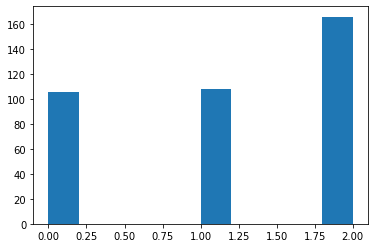

In [11]:
plt.hist(Y)

### Matrix and old skill computation

In [30]:

def names_to_index(Teams):

    """
    Creates a dictionary that associates teams to number
    """
    # dictionary comprehension
    d = {index: value for value, index in enumerate(Teams)}

    return d

In [13]:
def crea_matrici(X):
    """
    Takes as input a matrix X and their result to create two additional matrices that can be used for our model
    """
    #matrice casa trasferta risultato in numeri (N_match, 3)
    Y = np.array([3 if(X.iloc[i,3]=='H') else(0 if(X.iloc[i,3]=='A') else(1)) for i in range(X.shape[0])])
    
    d = names_to_index(Teams)
    
    T_1 = np.array([d[X.iloc[i,1]] for i in range(X.shape[0])])
    T_2 = np.array([d[X.iloc[i,2]] for i in range(X.shape[0])])
    T = np.unique([T_1,T_2])
    
    R = pd.DataFrame({"Home":T_1,"Away":T_2,"Result":Y})

    #matrice di storie delle squadre, casa-trasferta (N_Teams, 2)
    dim_vec_home = R['Home'].value_counts()
    dim_vec_away = R['Away'].value_counts()
    
    R2 = pd.DataFrame(index = sorted(T), columns = ["Home", "Away"])

    for k in range(len(np.unique(T_1))):
        i = np.unique(T_1)[k]
        R2["Home"][i] = np.empty(0,dtype = np.int8)
        j = np.unique(T_2)[k]
        R2["Away"][j] = np.empty(0,dtype = np.int8)
    for i in range(len(T_1)):
        h = R["Home"][i]
        a = R["Away"][i]
        R2["Home"][h] = np.append(R2["Home"][h],R["Result"][i])
        if(R["Result"][i]==1):                                      #Caso pareggi 1 punto
          R2["Away"][a] = np.append(R2["Away"][a], R["Result"][i])
        else:                                                       #Sconfitta 0 punti
          R2["Away"][a] = np.append(R2["Away"][a], 3 - R["Result"][i])
        
    
    
    return R,R2


In [14]:
def compute_skills(R,R2,init_home,init_away,l1=0.5, l2=0.5):
    """
    Takes as inputs a matrix X with teams and their result
    init is the inizialization of the skills, must be an array or list with the skill for each team.

    Returns two matrices with home and away skills parameters by team 
    and one matrix with skills parameters oredered cronologically
    """
    import numpy as np
    import pandas as pd

    N=R.shape[0] # number of matches
    

    #Creating matrices to store the skill parameters and their stories
        
    HS = pd.DataFrame(index = R2.index, columns = ["Home", "Away"])
  
    for i in range(R2.shape[0]):
        HS["Home"][i] = np.empty(0)
        HS["Away"][i] = np.empty(0)
        
    data = pd.DataFrame(index = R.index, columns=['Home','Away'])
    C = pd.DataFrame({"Home": np.zeros(len(R2.index), dtype = np.int8), "Away": np.zeros(len(R2.index), dtype = np.int8)})
    C.index = R2.index

    for i in range(R.shape[0]):
        h = R["Home"][i]
        a = R["Away"][i]

        #calcolo somma per xh
        sh = 0
        for j in range(C["Home"][h]):
            sh = sh + R2["Home"][h][j]*(1-l1)**j
        
        xh = l1*sh + init_home[h]*(1-l1)**C["Home"][h]

        #calcolo somma per xv
        sa = 0
        for j in range(C["Away"][a]):
            sa = sa + R2["Away"][a][j]*(1-l2)**j
        
        xv = l2*sa + init_away[a]*(1-l2)**C["Away"][a]
        
        #append nostra matrice storico e dati per stan
        HS["Home"][h] = np.append(HS["Home"][h],round(xh,3))
        HS["Away"][a] = np.append(HS["Away"][a],round(xv,3))
        data["Home"][i] = round(xh,3)
        data["Away"][i] = round(xv,3)
        
        #incremento counts
        C["Home"][h] += 1
        C["Away"][a] += 1

    return HS,data

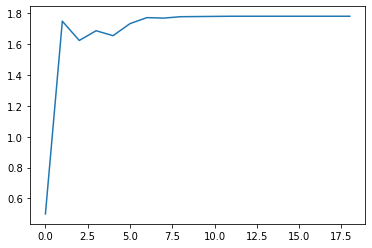

In [15]:
R_old, R2_old = crea_matrici(X)
HS_old, data_old = compute_skills(R_old, R2_old, 0.5*np.ones(len(Teams)), 0.5*np.ones(len(Teams)))

plt.plot(HS_old["Home"][0])

In [16]:
init_home = np.empty(0)
init_away = np.empty(0)

for i in range(HS_old.shape[0]):
  init_home = np.append(init_home,HS_old["Home"][i][-1])
  init_away = np.append(init_away,HS_old["Away"][i][-1])

R,R2 = crea_matrici(X)

## Final model

In [17]:
ordinal_reg = '''
data{
    int<lower=0> N; // Matches
    array[N] int y;
    int<lower=0> T; // Teams
    array[N,3] int R;  // Game+Result matrix
    array[T,2,19] int R2; // Teams' history
    vector[T] IH;    // init_home
    vector[T] IA;    // init_away
}

parameters { vector[2] beta; // coefficients for predictor variables 
            real intercept1;
            real<lower=intercept1+0.0001,upper=100000> intercept2;
            real<lower=0,upper=1> l1;
            real<lower=0,upper=1> l2;
}

transformed parameters {
  matrix[N,2] X;     // Skills
  real sh;
  real sa;
  vector[N] mu;
  vector[2] intercept;
  intercept[1] = intercept1;
  intercept[2] = intercept2;
  {
  array[T,2] int C=rep_array(0,T,2);

  for(i in 1:N){
    int h = R[i,1]+1; // Home team index
    int a = R[i,2]+1; // Away team index
    int ch = C[h,1]; // Home count
    int ca = C[a,2]; //Away count

    // Home team skill update
    if(ch==0){
      X[i,1] = IH[h];
    }
    else{
      sh=0;
      for(j in 1:ch){   
        sh=sh+R2[h,1,j]*pow((1-l1),j-1);
        }
      X[i,1]=l1*sh+IH[h]*pow((1-l1),ch);
    }

    // Away team skill update
    if(ca==0){
      X[i,2] = IA[a];
    }
    else{
      sa=0;
      for(j in 1:ca){   
        sa=sa+R2[a,2,j]*pow((1-l2),j-1);
      }
      X[i,2]=l2*sa+IA[a]*pow((1-l2),ca);
    }

    // Count update
    C[h,1]=C[h,1]+1;
    C[a,2]=C[a,2]+1;

    mu[i] = row(X, i) * beta;
  }

  }
}

model { // calculate likelihood of ordinal categories given predictor variable values and coefficients 
       
       beta[1] ~ normal(1.2,2);
       beta[2] ~ normal(-1.3,2);  
  
       intercept1 ~ normal(-0.6,2);
       intercept2 ~ normal(0.8,2);

       l1 ~ beta(3,3);
       l1 ~ beta(3,3);

       for (i in 1:N) { 
         y[i] ~ ordered_logistic(mu[i],intercept); } 
       }

'''

stan_file = "./ordinal_reg.stan"

with open(stan_file, "w") as f:
    print(ordinal_reg, file=f)

ordinal_reg = CmdStanModel(stan_file=stan_file)

07:06:15 - cmdstanpy - INFO - compiling stan file /content/ordinal_reg.stan to exe file /content/ordinal_reg
INFO:cmdstanpy:compiling stan file /content/ordinal_reg.stan to exe file /content/ordinal_reg
DEBUG:cmdstanpy:cmd: make /content/ordinal_reg
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/ordinal_reg.hpp /content/ordinal_reg.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/ordinal_reg.o /content/ordinal_reg.hpp
g++ -s

In [18]:
# Numero di partite da togliere
ntest = 40

In [19]:
Ydata = Y[:X.shape[0]-ntest]
R = R.head(X.shape[0]-ntest)

In [20]:
model_data = {'N': len(Ydata), 'y': Ydata+1, 'T': len(Teams), 'R': R, 'R2': R2.values.tolist(), 'IH': init_home, 'IA': init_away}

model_fit=ordinal_reg.sample(data=model_data, chains=4,
                           parallel_chains=4, iter_warmup=1000,
                           iter_sampling=5000)
model_data=az.from_cmdstanpy(model_fit)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxfsqat8/1qvha3wg.json
DEBUG:cmdstanpy:cmd: /content/ordinal_reg info
cwd: None
07:06:35 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/ordinal_reg', 'id=1', 'random', 'seed=10393', 'data', 'file=/tmp/tmpaxfsqat8/1qvha3wg.json', 'output', 'file=/tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/ordinal_reg', 'id=2', 'random', 'seed=10393', 'data', 'file=/tmp/tmpaxfsqat8/1qvha3wg.json', 'output', 'file=/tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/ordinal_reg', 'id=4', 'random', 'seed=10393', 'data', 'file=/tmp/tmpaxfsqat8/1qvha3wg.json', 

07:09:44 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/ordinal_reg', 'id=1', 'random', 'seed=10393', 'data', 'file=/tmp/tmpaxfsqat8/1qvha3wg.json', 'output', 'file=/tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_1.csv
 console_msgs (if any):
	/tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      

In [21]:
cmdstanpy_data = az.from_cmdstanpy(model_fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

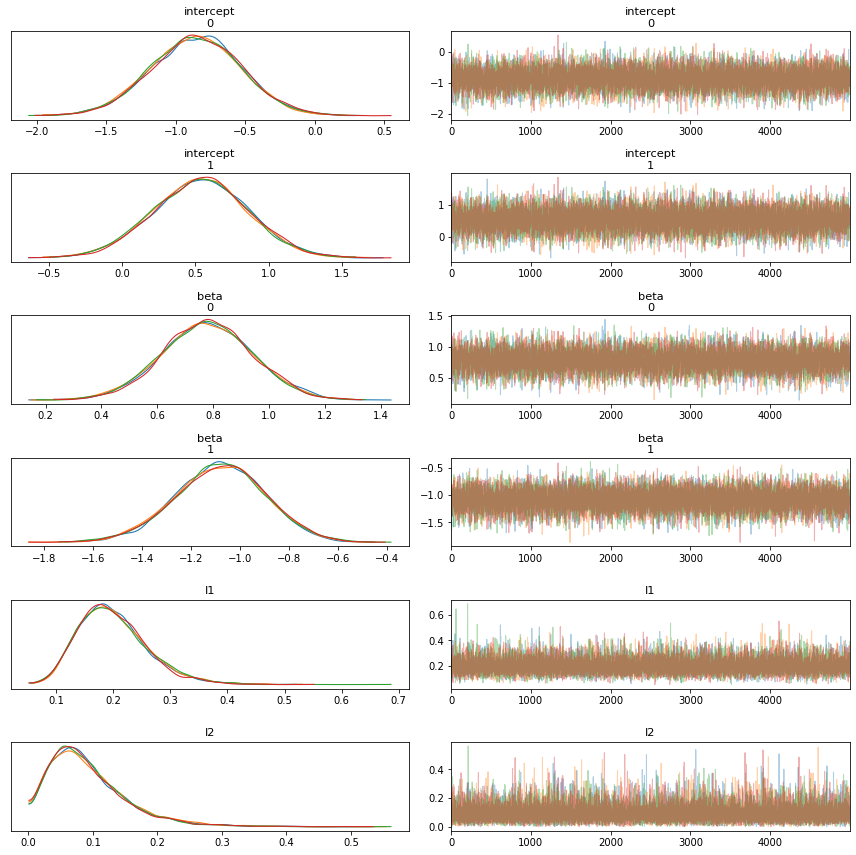

In [22]:
az.plot_trace(model_data, var_names=["intercept","beta","l1","l2"], compact=False)
plt.tight_layout()
#plt.savefig('ParamMod')
plt.show()


Test Prediction 

In [23]:
# Retrieve last match played by each team to retrieve last skill
def last_skill(SR):
  last_match_home = {}
  M = X.head(X.shape[0]-ntest)
  for team in Teams:
      team_matches = M[(M['HomeTeam'] == team)].sort_index(ascending=False)
      last_match_home[team] = team_matches.index[0]

  last_match_away = {}
  for team in Teams:
      team_matches = M[(M['AwayTeam'] == team)].sort_index(ascending=False)
      last_match_away[team] = team_matches.index[0]

  init_home = np.empty(0)
  init_away = np.empty(0)
  for team in Teams:
    sh = "X["+str(last_match_home[team])+",1]"
    init_home = np.append(init_home,SR[sh])
    sa = "X["+str(last_match_home[team])+",2]"
    init_away = np.append(init_away,SR[sa])
  
  return init_home,init_away

In [24]:
def prediction(model, new_data, SR):
  
  R, R2 = crea_matrici(new_data)
  
  #init_home,init_away = last_skill(SR)

  HS, data = compute_skills(R, R2, init_home, init_away, l1 = SR["l1"], l2 = SR["l2"])

  prob1 = []
  prob2 = []
  prob0 = []

  for i in range(new_data.shape[0]):
    odds1 = np.exp((-SR["intercept1"]) + SR["beta[1]"]*data["Home"][i] + SR["beta[2]"]*data["Away"][i])
    odds2 = np.exp((-SR["intercept2"]) + SR["beta[1]"]*data["Home"][i] + SR["beta[2]"]*data["Away"][i])
    prob1 = np.append(prob1, odds1/(odds1 + 1) - odds2/(odds2 + 1)) # PAREGGIO
    prob2 = np.append(prob2, odds2/(odds2 + 1)) # VITTORIA
    prob0 = np.append(prob0, 1-prob1[i]-prob2[i]) # SCONFITTA
  print("fine prediction")
  
  return prob0,prob1,prob2


Last 40 matches

In [25]:
new_data = X
SR = model_fit.summary()["Mean"]

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.31.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpaxfsqat8/stansummary-ordinal_reg-6wuk8ukm.csv /tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_1.csv /tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_2.csv /tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_3.csv /tmp/tmpaxfsqat8/ordinal_regdsha4ul2/ordinal_reg-20230213070635_4.csv
cwd: None


In [26]:
prob0,prob1,prob2 = prediction(model_fit, new_data, SR)

df = pd.DataFrame({'Column1': prob0, 'Column2': prob1, 'Column3': prob2})
df=df.tail(ntest)
max_column = df.idxmax(axis=1)
index = max_column.map(df.columns.get_loc)
y_pred = index.tolist()


print("Ne azzecchiamo il ",sum(X["Y"].tail(ntest)==y_pred)/ntest*100,"%")

fine prediction
Ne azzecchiamo il  40.0 %


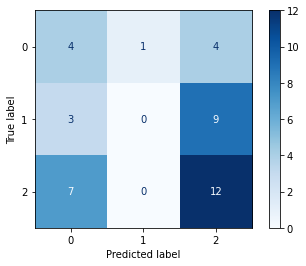

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.44      0.35         9
           1       0.00      0.00      0.00        12
           2       0.48      0.63      0.55        19

    accuracy                           0.40        40
   macro avg       0.26      0.36      0.30        40
weighted avg       0.29      0.40      0.34        40



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm= confusion_matrix(X["Y"].tail(ntest), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
target_names = ["0","1","2"]
print(classification_report(X["Y"].tail(ntest), y_pred, target_names=target_names))

In [28]:
for i in range(340):
  for j in range(2):
    sh = "X["+str(i+1)+","+str(j+1)+"]" 
 
    if((j+1)%2==0):
      print(SR[sh])
    else:
      print(SR[sh], end=" ")

0.267 2.996
1.379 2.053
0.607 1.599
1.708 0.793
1.108 0.916
2.687 1.42
1.004 1.743
1.782 0.114
2.937 1.25
2.921 0.628
1.188 0.966
2.873 0.278
0.557 0.55
2.676 0.29
1.246 1.156
2.281 0.994
1.779 1.081
1.389 0.783
2.438 1.85922
0.485809 1.28871
1.08644 2.99637
2.02518 0.719678
0.213692 0.263186
2.89836 0.923767
1.10367 0.103459
2.014 2.14056
2.74949 0.441
0.803545 1.72854
0.645448 0.981049
1.19688 0.902094
2.93677 0.318
1.15046 0.569934
1.96596 1.13442
2.74069 0.591608
2.94958 0.969144
1.31133 0.252296
2.02278 1.14158
2.42455 0.803064
2.21086 0.288597
2.79834 0.320039
2.91818 1.6005
0.913515 0.896403
2.05261 1.41522
0.391076 1.71965
0.328089 0.850418
0.558518 2.99669
1.35666 0.400225
2.55021 0.740366
1.11506 1.97617
1.00242 0.343208
1.74707 1.12908
1.12112 1.13471
2.79125 0.31011
2.95941 0.547567
2.9491 1.06272
1.25062 0.0943309
1.9012 1.27455
1.69939 0.599722
2.53677 0.891792
1.2179 0.840973
2.96715 2.04236
1.44853 1.39688
0.685053 0.996087
0.295288 1.11818
2.93378 0.755534
0.490092 0.3

In [29]:
R, R2 = crea_matrici(new_data)
HS, data = compute_skills(R, R2, init_home, init_away, l1 = SR["l1"], l2 = SR["l2"])

print(data.iloc[310:340,:])

      Home   Away
310  1.779   0.74
311  1.461  2.835
312  0.392  1.916
313  2.235  0.573
314  0.479  1.647
315  1.769  0.607
316  1.924  1.169
317  1.427  0.669
318  1.562  0.305
319  1.773  0.718
320  1.011  1.175
321  1.467  0.603
322  1.373  1.056
323  1.938  1.302
324   1.89  1.418
325    2.8  0.781
326  1.784  0.359
327  1.261  1.159
328   1.22  1.018
329  2.654  1.322
330  1.028   0.32
331  1.888  2.771
332  1.791  0.674
333   0.39  1.169
334  0.476  1.936
335  1.776  1.382
336  1.466  0.597
337  1.427  1.167
338  1.557  0.698
339  2.222  1.019
